In [1]:
import json
import logging
import struct
import zlib

In [2]:
logging.basicConfig(level=logging.INFO, format="[%(asctime)s][%(levelname)s] %(message)s")

In [3]:
# https://www.10xgenomics.com/datasets/visium-cytassist-gene-and-protein-expression-library-of-human-tonsil-with-add-on-antibodies-h-e-6-5-mm-ffpe-2-standard
# file_path = "datasets/CytAssist_FFPE_Protein_Expression_Human_Tonsil_cloupe.cloupe"

In [4]:
#iget -Kvfr /seq/illumina/runs/49/49384/spaceranger/spaceranger210_count_49384_pSKI_SP15018739_GRCh38-2020-A/cloupe.cloupe
file_path = "spaceranger210_count_49384_pSKI_SP15018739_GRCh38-2020-A.cloupe"

In [5]:
class Cloupe(object):

    def __init__(self, cloupe_path):
        self.cloupe_path = cloupe_path

        # read main header this is a json that has basic info
        # i'm assuming the header won't be larger than 4096 bytes and it's x00 padded at the end
        self.header = self.read_header()

        # index block will tell us where the data sections start/end
        # it's key for transversing all the sections:
        #   Runs, Matrices, Submatrices, Analyses, Projections, Clusterings, CellTracks,
        #   GeneTracks, Metrics, GeneLists, DiffExps, FeatureClasses, BarcodeClasses,
        #   PeakLocations, FragmentsIndex, GeneAnnotations, TranscriptAnnotations, CellDataTables
        #   BoolFilters, SpatialImages, SpatialImageTiles, SpatialImageSettings, SpatialEnrichments
        #   SpotDeconvolutions, FeatureLinkages, ClonotypeFiles
        self.index_block = self.read_block(
            start=self.header["indexBlock"]["Start"],
            end=self.header["indexBlock"]["End"],
            as_json=True,
        )

        # read Runs
        self.runs = []
        for run in self.index_block.get("Runs", []):
            if "Metadata" in run:
                run["Metadata"] = self.read_block(
                    start=run["Metadata"]["Start"],
                    end=run["Metadata"]["End"],
                    as_json=True,
                )
            self.runs.append(run)

        # read Metrics
        self.metrics = []
        for metric in self.index_block.get("Metrics", []):
            self.metrics.append(
                self.read_block(
                    start=metric["Contents"]["Start"],
                    end=metric["Contents"]["End"],
                    as_json=True,
                )
            )

        # read Analyses
        self.analyses = []
        for analysis in self.index_block["Analyses"]:
            self.analyses.append(analysis)

        # read Projections
        self.projections = {}
        for projection in self.index_block["Projections"]:
            try:
                # read data block
                pblock_bytes = self.read_block(
                    start=projection["Matrix"]["Start"],
                    end=projection["Matrix"]["End"],
                )
                pblock_count = projection["Matrix"]["ArraySize"]
                pblock = struct.unpack(f"{pblock_count}d", pblock_bytes)

                # read index block
                pindex_bytes = self.read_block(
                    start=projection["Matrix"]["Index"]["Start"],
                    end=projection["Matrix"]["Index"]["End"],
                )
                pindex_count = projection["Matrix"]["Index"]["ArraySize"]
                pindex = struct.unpack(f"{pindex_count}Q", pindex_bytes)

                # reashape so it has the dimensions of the matrix we want
                cols, rows = tuple(projection["Dims"])
                self.projections[projection["Name"]] = [
                    pblock[x : x + rows] for x in range(0, len(pblock), rows)
                ]
            except Exception as ex:
                logging.error(f"Projection '{projection['Name']}' error: {ex}")

        # read Matrices
        # Matrices have lots of properties, i'm only picking some, but the complete list is:
        #   Name', Uuid, FormatVersion, ParentUuid, Reference, GeneCount, CellCount, Genes, GeneNames,
        #   FeatureCount, BarcodeCount, Metadata, Barcodes, FeatureIds, FeatureNames, FeatureSecondaryNames,
        #   FeatureTypeOffsets, FeatureTypeIndices, CSCValues, CSCPointers, CSCIndices, CSRValues, CSRPointers,
        #   CSRIndices, UMICounts
        self.matrices = []
        for matrix in self.index_block["Matrices"]:
            try:
                for prop in ["Barcodes","FeatureIds","FeatureNames","FeatureSecondaryNames",]:
                    if prop not in matrix:
                        continue
                    mblock = self.read_block(
                        start=matrix[prop]["Start"], end=matrix[prop]["End"]
                    )
                    step = matrix[prop]["ArrayWidth"]
                    stop = matrix[prop]["ArraySize"] * step
                    matrix[prop] = [
                        mblock[i : i + step]
                        .decode("utf-8", errors="replace")
                        .strip("\x00")
                        for i in range(0, stop, step)
                    ]
                umicounts_bytes = self.read_block(
                    start=matrix["UMICounts"]["Start"],
                    end=matrix["UMICounts"]["End"],
                )
                umicounts_count = matrix["UMICounts"]["ArraySize"]
                matrix["UMICounts"] = struct.unpack(
                    f"{umicounts_count}Q", umicounts_bytes
                )
                self.matrices.append(matrix)
            except Exception as ex:
                logging.error(f"Matrix '{matrix['Name']}' error: {ex}")

        # read the next header
        # this looks like that is where the custom user data is written
        # there could be several chained headers by nextHeaderOffest but i'm only
        # gonna parse the first one and i'll only get CellTracks, however, more
        # stuff could be here that we want to export
        self.celltracks = []
        if self.header["nextHeaderOffset"] != self.get_file_size():
            self.next_header = self.read_header(self.header["nextHeaderOffset"])
            self.next_index_block = self.read_block(
                start=self.next_header["indexBlock"]["Start"],
                end=self.next_header["indexBlock"]["End"],
                as_json=True,
            )
            # now that we have the index block we get the 'userCreated' celltracks
            self.celltracks = []
            for celltrack in self.next_index_block["CellTracks"]:
                celltrack["Metadata"] = self.read_block(
                    start=celltrack["Metadata"]["Start"],
                    end=celltrack["Metadata"]["End"],
                    as_json=True,
                )
                vblock_bytes = self.read_block(
                    start=celltrack["Values"]["Start"],
                    end=celltrack["Values"]["End"],
                )
                vblock_count = celltrack["Values"]["ArraySize"]
                groups = celltrack["Metadata"]["groups"]
                group_keys = struct.unpack(f"{vblock_count}h", vblock_bytes)
                celltrack["Values"] = [groups[gk] if gk!=-1 else "UNASSIGNED" for gk in group_keys]
                self.celltracks.append(celltrack)

    def read_header(self, position=0):
        with open(self.cloupe_path, "rb") as f:
            f.seek(position)
            header = f.read(4096)
            return json.loads(header.decode("utf-8", errors="replace").strip("\x00"))

    def get_file_size(self):
        with open(self.cloupe_path, "rb") as f:
            f.seek(0, 2)
            size = f.tell()
            return size

    def __repr__(self):
        return str(self.index_block["Runs"])

    # trick for partial object decompression
    def decompress(self, chunk):
        gz = zlib.decompressobj(31)
        return gz.decompress(chunk)

    # read cloupe block
    def read_block(self, start, end, as_json=False):
        with open(self.cloupe_path, "rb") as f:
            f.seek(start)
            read_size = end - start
            block = f.read(read_size)
            if block[:2] == b"\x1f\x8b":
                logging.debug("compressed block")
                block = self.decompress(block)
            if as_json:
                return json.loads(block.decode("utf-8", errors="replace"))
            return block


# Load cloupe file

In [6]:
cloupe = Cloupe(file_path)

# Basic strcutre
- Uuid           `cloupe.header`
- FormatVersion  `cloupe.header`
- Runs           `cloupe.runs`
- Metrics        `cloupe.metrics`
- Matrices       `cloupe.matrices`
- Analyses       `cloupe.analyses`
- Projections    `cloupe.projections`

# Matrices (barcodes and features)

In [7]:
len(cloupe.matrices)

1

In [8]:
for prop in ['FeatureCount', 'BarcodeCount']:
    print(prop, cloupe.matrices[0][prop])

FeatureCount 36603
BarcodeCount 470


In [9]:
cloupe.matrices[0].keys()

dict_keys(['GeneCount', 'CellCount', 'Genes', 'GeneNames', 'Name', 'Uuid', 'FormatVersion', 'ParentUuid', 'Reference', 'FeatureCount', 'BarcodeCount', 'Metadata', 'Barcodes', 'FeatureIds', 'FeatureNames', 'FeatureSecondaryNames', 'FeatureTypeOffsets', 'FeatureTypeIndices', 'CSCValues', 'CSCPointers', 'CSCIndices', 'CSRValues', 'CSRPointers', 'CSRIndices', 'UMICounts'])

In [10]:
cloupe.matrices[0]['Barcodes'][:10]

['AAACCGTTCGTCCAGG-1',
 'AAACGAGACGGTTGAT-1',
 'AAACTCGTGATATAAG-1',
 'AAACTGCTGGCTCCAA-1',
 'AAATACCTATAAGCAT-1',
 'AAATAGCTTAGACTTT-1',
 'AAATCGTGTACCACAA-1',
 'AACATATCAACTGGTG-1',
 'AACCCTACTGTCAATA-1',
 'AACGGCCATCTCCGGT-1']

In [11]:
cloupe.matrices[0]['FeatureIds'][:10]

['ENSG00000243485',
 'ENSG00000237613',
 'ENSG00000186092',
 'ENSG00000238009',
 'ENSG00000239945',
 'ENSG00000239906',
 'ENSG00000241860',
 'ENSG00000241599',
 'ENSG00000286448',
 'ENSG00000236601']

In [12]:
cloupe.matrices[0]['FeatureNames'][:10]

['MIR1302-2HG',
 'FAM138A',
 'OR4F5',
 'AL627309.1',
 'AL627309.3',
 'AL627309.2',
 'AL627309.5',
 'AL627309.4',
 'AP006222.2',
 'AL732372.1']

# Projections/Embeddings

In [13]:
[p for p in cloupe.projections]

['tsne', 'UMAP', 'Spatial', 'Fiducials']

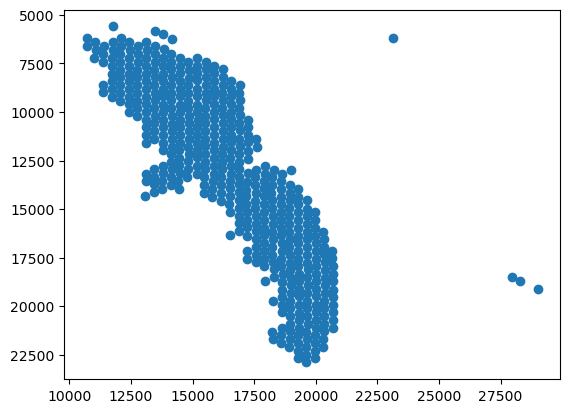

In [14]:
import matplotlib.pyplot as plt
spatial_embedding = cloupe.projections['Spatial']
plt.scatter(x=spatial_embedding[0], y=spatial_embedding[1])
plt.gca().invert_yaxis()
plt.show()

# Spatial image

In [15]:
cloupe.index_block['SpatialImages']

[{'Name': 'PLP7_1.jpg',
  'Uuid': '4949f0d2-e392-4854-b44d-f33a08fd1d79',
  'FormatVersion': '1.1.0',
  'ParentUuid': 'a154a637-9ae8-4f85-b344-efdddab8a860',
  'Metadata': None,
  'Dims': [32403, 32653],
  'Format': 'png',
  'ImageData': None,
  'ImagePath': '',
  'Checksum': '',
  'Channel': 0,
  'Type': 'brightfield'}]

### Export image tiles

In [16]:
import os
output_path = "spatial-image-tiles"
for k,v in cloupe.index_block['SpatialImageTiles'][0]['Tiles'].items():
    png_path = os.path.join(output_path, k)
    os.makedirs(os.path.dirname(png_path), exist_ok=True)
    with open(png_path,"wb") as png:
        png.write(cloupe.read_block(start=v['Start'], end=v['End']))

### View lowest resolution

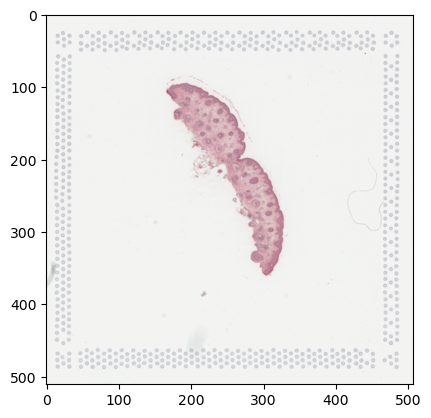

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
output_path = "spatial-image-tiles"
png_path = os.path.join(output_path, "9", "0_0.png")
imgplot = plt.imshow(mpimg.imread(png_path))
plt.show()

# User annotations

In [18]:
for ct in cloupe.celltracks:
    print(ct["Name"])
    for g in ct['Metadata']['groups']:
        print(f"  - {g}")

xy
  - ClusterX
  - ClusterY
only one
  - cluster1


In [19]:
barclodes_clusters = list(zip(cloupe.matrices[0]["Barcodes"], cloupe.celltracks[0]["Values"]))

for barcode,cluster in barclodes_clusters[:10]:
    print(barcode, cluster)

AAACCGTTCGTCCAGG-1 ClusterX
AAACGAGACGGTTGAT-1 ClusterX
AAACTCGTGATATAAG-1 ClusterX
AAACTGCTGGCTCCAA-1 ClusterX
AAATACCTATAAGCAT-1 ClusterX
AAATAGCTTAGACTTT-1 ClusterX
AAATCGTGTACCACAA-1 ClusterX
AACATATCAACTGGTG-1 ClusterX
AACCCTACTGTCAATA-1 ClusterX
AACGGCCATCTCCGGT-1 ClusterY
